In [1]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 7.4 MB/s eta 0:00:00


In [2]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.7 MB/s eta 0:00:00


In [3]:
!pip install -U transformers



---

Step 1: Import Libraries


---


*  Data handling: pandas, numpy
*  Text processing: re, emoji
*  Machine learning (scikit-learn): train_test_split, TfidfVectorizer, CountVectorizer, LogisticRegression, SVC, accuracy_score, classification_report
*  Deep learning (TensorFlow/Keras): tensorflow, Tokenizer, pad_sequences, to_categorical
*  Transformers (Hugging Face): BertTokenizer, TFBertForSequenceClassification
CountVectorizer, LogisticRegression, SVC, accuracy_score, classification_report

In [76]:
# ==========================
# Standard Python Libraries
# ==========================
import os
import re
import pickle
import joblib

# ==========================
# Data Handling & Analysis
# ==========================
import pandas as pd
import numpy as np

# ==========================
# Visualization
# ==========================
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================
# Preprocessing & Feature Extraction
# ==========================
import emoji
import contractions
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# ==========================
# Classical ML Models
# ==========================
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, classification_report

# ==========================
# TensorFlow / Keras (for LSTM)
# ==========================
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# ==========================
# Hugging Face Transformers (PyTorch)
# ==========================
import torch
from torch.utils.data import DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, get_scheduler
from torch.optim import AdamW
from datasets import Dataset
from tqdm import tqdm




---


Step 2: Load Dataset

---



In [ ]:
# Load your CSV dataset
df = pd.read_csv('semtiment140_analysis_dataset.csv', encoding='latin-1', header=None)

# Rename columns for easier handling
df.columns = ['sentiment', 'id', 'date', 'query', 'user', 'text']

# Map sentiment 0 -> negative, 4 -> positive
df['sentiment'] = df['sentiment'].map({0: 'negative', 4: 'positive'})


In [ ]:
df.shape
df.head()

,sentiment,id,date,query,user,text
0,negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,negative,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,negative,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,negative,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


---
**Step 3: Clean Text & Handle Emojis**


---


*  Remove URLs, mentions, hashtags, special characters
*  Convert emojis to descriptive text (emoji.demojize)
*  Expand contractions






In [ ]:
def clean_text(text):
    # 1️⃣ Convert emojis to descriptive text
    text = emoji.demojize(text)

    # 2️⃣ Expand contractions (e.g., "don't" -> "do not")
    text = contractions.fix(text)

    # 3️⃣ Lowercase everything
    text = text.lower()

    # 4️⃣ Remove URLs, mentions, hashtags
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"@\w+", '', text)
    text = re.sub(r"#\w+", '', text)

    # 5️⃣ Replace numbers with a token (optional but helpful)
    text = re.sub(r'\d+', '<num>', text)

    # 6️⃣ Keep letters, numbers, spaces, basic punctuation, and emoji codes
    #    (keeping ! ? : since they show emotion or emoji codes)
    text = re.sub(r"[^a-zA-Z0-9\s:!?]", '', text)

    # 7️⃣ Replace multiple exclamation/question marks with single ones (normalize)
    text = re.sub(r'!{2,}', '!', text)
    text = re.sub(r'\?{2,}', '?', text)

    # 8️⃣ Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text




---


Step 4: Split

---



In [ ]:
df['clean_text'] = df['text'].apply(clean_text)

X = df['clean_text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")


Training samples: 1280000, Test samples: 320000




---


Step 5: Feature Extraction for ML Models

---



In [ ]:
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)




---


Step 6: Train ML Models

---



**Logistic Regression**

---


What it is:

- Logistic Regression is a linear model for classification.

- It predicts the probability of each class (Positive, Negative, Neutral) and chooses the class with the highest probability.

How it works:

- Convert your text into numbers using TF-IDF (so the model can understand words as features).

- Train the Logistic Regression model on your training data.

- The model finds weights for each feature to best separate the classes.

- Test the model on new text and check accuracy.



In [ ]:
lr = LogisticRegression(max_iter=5000)
lr.fit(X_train_tfidf, y_train)
y_pred = lr.predict(X_test_tfidf)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Logistic Regression Accuracy: 0.789859375
              precision    recall  f1-score   support

    negative       0.80      0.78      0.79    159494
    positive       0.78      0.80      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



LinearSVC ML

---

What it is:

- LinearSVC is also a linear classifier like Logistic Regression

- But instead of probabilities, it finds a hyperplane that separates the classes with the largest margin

How it works:

- Convert text into numbers using TF-IDF

- Train LinearSVC on the training data

- The model tries to draw a line (or hyperplane in many dimensions) that separates Positive, Negative, and Neutral as clearly as possible

- Test the model and check accuracy

In [ ]:
svm = LinearSVC(C=1.0, max_iter=5000)
svm.fit(X_train_tfidf, y_train)
y_pred = svm.predict(X_test_tfidf)

print("SVM Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

SVM Accuracy: 0.789525
              precision    recall  f1-score   support

    negative       0.80      0.77      0.79    159494
    positive       0.78      0.81      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000





---


Step 7: Prepare Data for LSTM

---



In [68]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 50
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Encode labels
y_train_enc = y_train.map({'negative':0, 'positive':1}).values
y_test_enc = y_test.map({'negative':0, 'positive':1}).values
y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

NameError: name 'X_train' is not defined



---


Step 8: Build & Train LSTM

---
What it is:

- LSTM is a deep learning model specifically for sequential data like text.

- It can remember important words from earlier in the sentence when making predictions.

Step by step explanation:

- Convert text into numbers using tokenization (words become sequences of numbers).

- Feed sequences into the LSTM model.

- LSTM uses memory cells to capture context and patterns in text.

- Output a prediction for Positive, Negative, or Neutral.



In [ ]:
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=max_len))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

model.fit(X_train_pad, y_train_cat, epochs=3, batch_size=128, validation_split=0.1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
9000/9000 ━━━━━━━━━━━━━━━━━━━━ 1029s 114ms/step - accuracy: 0.7857 - loss: 0.4538 - val_accuracy: 0.8172 - val_loss: 0.4008
Epoch 2/3
9000/9000 ━━━━━━━━━━━━━━━━━━━━ 981s 109ms/step - accuracy: 0.8235 - loss: 0.3913 - val_accuracy: 0.8199 - val_loss: 0.3954
Epoch 3/3
9000/9000 ━━━━━━━━━━━━━━━━━━━━ 986s 110ms/step - accuracy: 0.8339 - loss: 0.3714 - val_accuracy: 0.8228 - val_loss: 0.3919




---


Visualization

---



/tmp/ipython-input-187242383.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=algorithms, y=accuracy_scores, palette=['#3B82F6','#22C55E','#EF4444'])


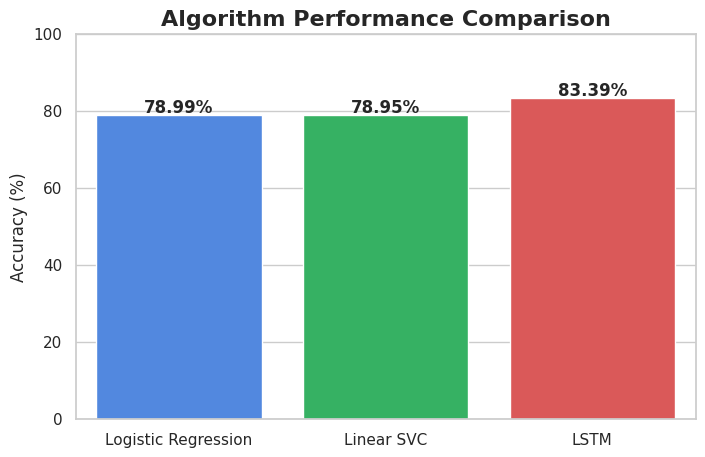

In [66]:
# Data
algorithms = ['Logistic Regression', 'Linear SVC', 'LSTM']
accuracy_scores = [0.7899*100, 0.7895*100, 0.8339*100]

# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(8,5))
barplot = sns.barplot(x=algorithms, y=accuracy_scores, palette=['#3B82F6','#22C55E','#EF4444'])

# Add labels
for i, score in enumerate(accuracy_scores):
    barplot.text(i, score + 0.5, f'{score:.2f}%', ha='center', fontweight='bold')

plt.title('Algorithm Performance Comparison', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.show()



---

Step 9: Save Model Process

---



In [71]:
#Mount Google Drive in Colab
from google.colab import drive
drive.mount('/content/drive')

# Create folder inside Drive
os.makedirs('/content/drive/MyDrive/saved_models', exist_ok=True)
print("Folder created at Google Drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Folder created at Google Drive


Save Model


---

Once it already saved we don't need to run this again


In [ ]:

# -----------------------------
# Save Logistic Regression
# -----------------------------
# Re-define and train the Logistic Regression model if not already done
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

lr = LogisticRegression(max_iter=5000)
lr.fit(X_train_tfidf, y_train)

joblib.dump(lr, f'{save_folder}/logistic_regression.pkl')
print(f"Logistic Regression saved at {save_folder}/logistic_regression.pkl")

# -----------------------------
# Save TF-IDF Vectorizer
# -----------------------------
joblib.dump(tfidf, f'{save_folder}/tfidf_vectorizer.pkl')
print(f"TF-IDF Vectorizer saved at {save_folder}/tfidf_vectorizer.pkl")

# -----------------------------
# Save LSTM model
# -----------------------------
model.save(f'{save_folder}/lstm_model_full.keras')
print(f"LSTM saved at {save_folder}/lstm_model_full.keras")

Save preprocessing objects

In [ ]:
joblib.dump(tfidf_vectorizer, '/content/drive/MyDrive/saved_models/tfidf_vectorizer.pkl')
with open('/content/drive/MyDrive/saved_models/lstm_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)


In [ ]:
with open('/content/drive/MyDrive/saved_models/max_len.pkl', 'wb') as f:
    pickle.dump(MAX_LEN, f)




---

Step 10: Load the model

---



In [72]:
save_folder = '/content/drive/MyDrive/saved_models'

# Load ML models
lr_model = joblib.load(f'{save_folder}/logistic_regression.pkl')
svc_model = joblib.load(f'{save_folder}/linear_svc.pkl')

# Load LSTM
lstm_model = load_model(f'{save_folder}/lstm_model_full.keras')

# Load preprocessing
tfidf_vectorizer = joblib.load(f'{save_folder}/tfidf_vectorizer.pkl')
with open(f'{save_folder}/lstm_tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Load or define MAX_LEN
try:
    with open(f'{save_folder}/max_len.pkl', 'rb') as f:
        MAX_LEN = pickle.load(f)
except:
    MAX_LEN = 50  # replace with the value used in training

Define a prediction function

In [ ]:
from scipy.special import softmax

def predict_sentiment(text, model_type='lr'):
    """
    Predict sentiment using LR, SVC, or LSTM.
    Returns:
        pred_label: 'Positive' or 'Negative'
        probs_percent: list of percentages [negative, positive]
    """
    if model_type == 'lr':
        X = tfidf_vectorizer.transform([text])
        probs = lr_model.predict_proba(X)[0]
        pred_label = lr_model.predict(X)[0]

    elif model_type == 'svc':
        X = tfidf_vectorizer.transform([text])
        decision = svc_model.decision_function(X)[0]
        probs = softmax([-decision, decision])
        pred_label = svc_model.predict(X)[0]

    elif model_type == 'lstm':
        seq = tokenizer.texts_to_sequences([text])
        padded = pad_sequences(seq, maxlen=MAX_LEN)
        pred = lstm_model.predict(padded)[0]  # softmax output: [negative, positive]
        probs = pred
        pred_label = 'Positive' if pred[1] > pred[0] else 'Negative'

    else:
        raise ValueError("Choose model_type as 'lr', 'svc', or 'lstm'.")

    # Convert probabilities to percentages
    probs_percent = [f"{p*100:.2f}%" for p in probs]
    return pred_label, probs_percent


def display_sentiment_clean(text):
    """
    Display all three model predictions neatly.
    """
    for model_type in ['lr', 'svc', 'lstm']:
        label, probs = predict_sentiment(text, model_type)
        print(f"Model: {model_type.upper()}")
        print(f"Predicted Sentiment: {label}")
        print(f"Confidence: Positive = {probs[1]}, Negative = {probs[0]}")
        print("-"*50)




Demo text

In [ ]:
# Get input from user
text = input("Enter a sentence: ")

# Display all models neatly
display_sentiment_clean(text)
